In [199]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import make_grid

In [200]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

In [201]:
# HYPERPARAMETERS
batch_size = 64
learning_rate = 1e-3
max_iters = 10000

In [202]:
transform = transforms.Compose([
    transforms.ToTensor(), # Converts the inputs to tensors, scales the values to [0,1]
    # transforms.Normalize((0.5,), (0.5,)), # Shifts and scales the mean and standard deviation
])

In [203]:
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

In [204]:
# Shuffle train data to break artifical correlations in the original order
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# DO NOT shuffle test data to keep consistency
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [218]:
class DenoisingAutoencoder(nn.Module):

    def __init__(self):
        super().__init__()
        # LAYERS
        self.encoder = nn.Sequential(
            # The first Conv2d layer takes a single image
            # It applies 16 different 3x3 kernels with stride 1
            # We add a padding of 1 for the edges (If we had 5x5 kernels, we should use padding of 2)

            # Input dim is (1, 28, 28)
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            # Dim is (16, 28, 28), (one for each kernel)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # Kernel size of 2, stride of 2
            # Dim is halved to (16, 14, 14)
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            # Dim is (32, 14, 14)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
            # Dim is halved to (32, 7, 7)
        )
        self.decoder = nn.Sequential(
            # Input dim is (32, 7, 7) (output of encoder)
            nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2),
            # Dim is doubled to (32, 14, 14)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=2, stride=2),
            # Dim is doubled to (32, 28, 28)
            nn.Sigmoid() # End with sigmoid since we want to output numbers in [0,1]
        )
            
    def forward(self, x):
        # Input has dim (B, 28, 28)
        # Values already in range of [0,1] due to how we loaded it
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [151]:
def add_noise(x, std):
    # x has shape (Batch size, Channels, Height, Width)
    noise = torch.randn(x.size(), device=x.device)
    noise = noise * std # Scale the noise by the desired standard deviation
    x = x + noise
    x = torch.clamp(x, min=0, max=1)
    return x

In [162]:
def add_noise2(x, prob):
    output = x.clone()

    num_salt = int(prob * x.numel() * 0.5)
    coords = [torch.randint(0, i, (int(num_salt),)) for i in x.size()]
    output[coords] = 1

    num_pepper = int(prob * x.numel() * 0.5)
    coords = [torch.randint(0, i, (int(num_pepper),)) for i in x.size()]
    output[coords] = 0

    return output

In [158]:
def visualize_grid(tensor):
    # Unnormalize pixel values
    # mean = 0.5
    # std = 0.5
    # tensor = tensor * std + mean
    
    grid = make_grid(tensor)

    image = grid.cpu().numpy()

    image = np.transpose(image, (1, 2, 0))

    plt.imshow(image)
    plt.axis('off')
    plt.show

In [167]:
xb, _ = next(iter(train_loader))
xb = xb.to(device)
xb_noisy = xb + 0.5 * torch.randn(*xb.shape, device=device)

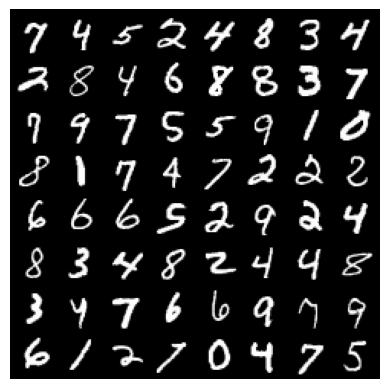

In [168]:
visualize_grid(xb)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0499356..2.674113].


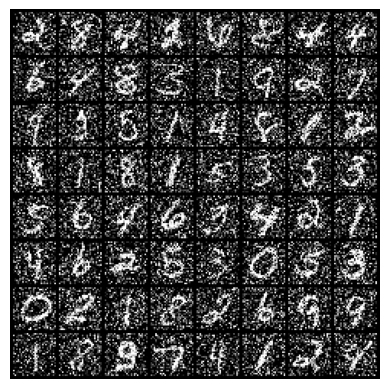

In [173]:
visualize_grid(xb_noisy)

In [219]:
model = DenoisingAutoencoder().to(device)
# model = model.to(device)
loss_fn = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.1)

tensor([[[0.5144, 0.5260, 0.5060, 0.5452, 0.5141, 0.5270, 0.5060, 0.5450,
          0.5141, 0.5270, 0.5060, 0.5450, 0.5141, 0.5270, 0.5060, 0.5450,
          0.5140, 0.5268, 0.5057, 0.5453, 0.5139, 0.5273, 0.5057, 0.5454,
          0.5145, 0.5255, 0.5034, 0.5475],
         [0.5083, 0.4966, 0.4998, 0.4992, 0.5078, 0.4969, 0.4995, 0.4989,
          0.5078, 0.4969, 0.4995, 0.4989, 0.5078, 0.4969, 0.4995, 0.4989,
          0.5078, 0.4970, 0.4994, 0.4988, 0.5076, 0.4971, 0.4992, 0.4991,
          0.5094, 0.4963, 0.5005, 0.4990],
         [0.5157, 0.5350, 0.5174, 0.5236, 0.5161, 0.5344, 0.5173, 0.5234,
          0.5161, 0.5344, 0.5173, 0.5234, 0.5161, 0.5344, 0.5173, 0.5234,
          0.5161, 0.5345, 0.5176, 0.5233, 0.5161, 0.5345, 0.5177, 0.5233,
          0.5178, 0.5345, 0.5183, 0.5237],
         [0.5009, 0.4993, 0.5048, 0.5002, 0.5014, 0.4986, 0.5054, 0.4997,
          0.5014, 0.4986, 0.5054, 0.4997, 0.5014, 0.4986, 0.5054, 0.4997,
          0.5016, 0.4984, 0.5052, 0.4997, 0.5016, 0.4983,

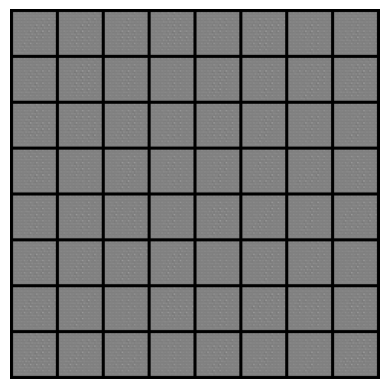

In [220]:
xb_model = model(xb)
visualize_grid(xb_model)
print(xb_model[0])

In [223]:
loss_data = []

noise_factor = 0.5

for i in range(1, max_iters+1):

    xb, _ = next(iter(train_loader))
    xb = xb.to(device)

    xb_noisy = xb + noise_factor * torch.randn(*xb.shape, device=device)
    xb_noisy = torch.clamp(xb_noisy, min=0, max=1)
    xb_noisy = xb_noisy.to(device)

    optimizer.zero_grad() # RESET GRADS

    output = model(xb)

    loss = loss_fn(xb_noisy, xb)
    loss.requires_grad = True

    loss.backward()

    optimizer.step()

    loss_data.append(loss.item())
    if i % 100 == 0:
        print(f"{i}/{max_iters} | Loss: {loss.item():.4f}")

100/10000 | Loss: 0.1156
200/10000 | Loss: 0.1161
300/10000 | Loss: 0.1154
400/10000 | Loss: 0.1148
500/10000 | Loss: 0.1156
600/10000 | Loss: 0.1158
700/10000 | Loss: 0.1150
800/10000 | Loss: 0.1144
900/10000 | Loss: 0.1160
1000/10000 | Loss: 0.1154
1100/10000 | Loss: 0.1154
1200/10000 | Loss: 0.1159
1300/10000 | Loss: 0.1140
1400/10000 | Loss: 0.1165
1500/10000 | Loss: 0.1172
1600/10000 | Loss: 0.1137
1700/10000 | Loss: 0.1142
1800/10000 | Loss: 0.1158
1900/10000 | Loss: 0.1152
2000/10000 | Loss: 0.1155
2100/10000 | Loss: 0.1147
2200/10000 | Loss: 0.1168
2300/10000 | Loss: 0.1172
2400/10000 | Loss: 0.1153
2500/10000 | Loss: 0.1147
2600/10000 | Loss: 0.1144
2700/10000 | Loss: 0.1137
2800/10000 | Loss: 0.1151
2900/10000 | Loss: 0.1158
3000/10000 | Loss: 0.1157
3100/10000 | Loss: 0.1150
3200/10000 | Loss: 0.1158
3300/10000 | Loss: 0.1157
3400/10000 | Loss: 0.1171
3500/10000 | Loss: 0.1162
3600/10000 | Loss: 0.1155
3700/10000 | Loss: 0.1154
3800/10000 | Loss: 0.1159
3900/10000 | Loss: 0.

In [ ]:
xb, _ = next(iter(train_loader))

xb_noisy = add_noise2(xb, prob=0.2)

xb = xb.to(device)
xb_noisy = xb_noisy.to(device)

visualize_grid(model(xb_noisy))
model(xb_noisy)